## Preprocess data

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy.random as npr
import json

from edward.models import Normal

plt.style.use('ggplot')

/Users/yixinwang/py2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
credits = pd.read_csv("../dat/tmdb_raw/tmdb-5000-movie-dataset/tmdb_5000_credits.csv")
movies = pd.read_csv("../dat/tmdb_raw/tmdb-5000-movie-dataset/tmdb_5000_movies.csv")

In [3]:
# movies.head()

In [4]:
# credits.head()

In [5]:
tmdb = pd.merge(movies, credits, left_on="id", right_on="movie_id")

In [6]:
# tmdb.head()

In [7]:
tmdb.columns.values

array(['budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title_x', 'vote_average', 'vote_count', 'movie_id', 'title_y',
       'cast', 'crew'], dtype=object)

In [8]:
tmdb.drop(['homepage', 'id', 'keywords', 'original_title', \
           'overview', 'release_date', 'tagline', 'title_x', \
           'title_y', 'crew'], axis=1, inplace=True)
tmdb["log_profit_rate"] = np.log(tmdb["revenue"] / tmdb["budget"])
tmdb["log_profit_rate"] = tmdb["log_profit_rate"].replace([np.inf, -np.inf], np.nan)
tmdb = tmdb.dropna()


/Users/yixinwang/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


(array([   5.,    0.,   12.,   90., 1388., 1683.,   46.,    3.,    0.,
           2.]), array([-14.46609812, -11.42393064,  -8.38176315,  -5.33959567,
         -2.29742819,   0.7447393 ,   3.78690678,   6.82907427,
          9.87124175,  12.91340924,  15.95557672]), <a list of 10 Patch objects>)

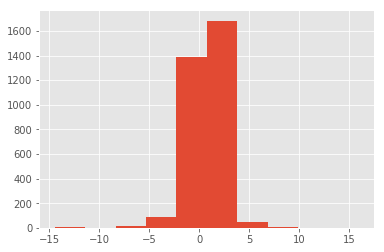

In [9]:
plt.hist(tmdb["log_profit_rate"])

In [10]:
tmdb = tmdb[tmdb["log_profit_rate"].abs() < 6] # delete outliers

(array([  15.,   31.,   56.,  174.,  569., 1301.,  833.,  174.,   41.,
          12.]),
 array([-5.70746783, -4.5472678 , -3.38706777, -2.22686774, -1.06666771,
         0.09353232,  1.25373235,  2.41393238,  3.57413241,  4.73433244,
         5.89453246]),
 <a list of 10 Patch objects>)

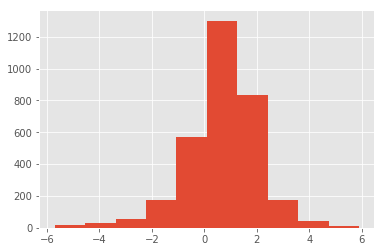

In [11]:
plt.hist(tmdb["log_profit_rate"])

In [12]:
tmdb = tmdb[tmdb["status"]=="Released"]
tmdb.drop(['status'], axis=1, inplace=True)

In [13]:
tmdb.index = pd.RangeIndex(len(tmdb.index))

In [14]:
tmdb.head()

,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count,movie_id,cast,log_profit_rate
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...",2.465007
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...",1.164192
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...",1.279430
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...",1.467818
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...",0.088782


In [15]:
genres_list = [(np.array(pd.read_json(tmdb['genres'][row])), \
                tmdb["movie_id"][row]) for row in tmdb.index]
genres = np.concatenate([np.column_stack(\
                                         (np.tile(old_movie_id, genre.shape[0]), \
                                          genre)) \
                         for genre, old_movie_id in genres_list \
                         if genre.shape[0] > 0 ])

In [16]:
genres_df = pd.DataFrame(genres, columns=['movie_id', 'genre_id', 'genre'])

In [17]:
genres_df.head()

,movie_id,genre_id,genre
0,19995,28,Action
1,19995,12,Adventure
2,19995,14,Fantasy
3,19995,878,Science Fiction
4,285,12,Adventure


In [18]:
genres_df["genre"].value_counts()

Drama              1427
Comedy             1100
Thriller            929
Action              916
Adventure           660
Romance             571
Crime               519
Science Fiction     430
Family              363
Fantasy             339
Horror              326
Mystery             262
Animation           187
History             144
War                 119
Music               110
Western              57
Documentary          36
Foreign               5
Name: genre, dtype: int64

In [19]:
new_genres_id_table = np.column_stack((genres_df.genre_id.unique(), range(len(genres_df.genre_id.unique()))))
new_genres_id_table = pd.DataFrame(new_genres_id_table, columns=['genre_id', 'new_genre_id'])
genres_df = pd.merge(genres_df, new_genres_id_table, left_on="genre_id", right_on="genre_id")

In [20]:
genres_df.head()

,movie_id,genre_id,genre,new_genre_id
0,19995,28,Action,0
1,285,28,Action,0
2,206647,28,Action,0
3,49026,28,Action,0
4,49529,28,Action,0


In [21]:
casts_list = [(np.array(pd.read_json(tmdb['cast'][row])), \
               tmdb["movie_id"][row]) for row in tmdb.index]
casts = np.concatenate([np.column_stack(\
                                        (np.tile(old_movie_id, cast.shape[0]), \
                                         cast)) \
                        for cast, old_movie_id in casts_list \
                        if cast.shape[0] > 0 ])

In [22]:
casts_df = pd.DataFrame(casts, columns=['movie_id', 'cast_id', \
                                        'character', 'credit_id', 'gender', \
                                        'actor_id', 'name', 'order'])

In [23]:
casts_df.describe()

,movie_id,cast_id,character,credit_id,gender,actor_id,name,order
count,83754,83754,83754,83754,83754,83754,83754,83754
unique,3203,524,58181,83754,3,45291,45013,225
top,80585,4,Himself,52fe48f7c3a36847f81828a9,2,2231,Samuel L. Jackson,1
freq,224,1760,508,1,38589,53,53,3185


(array([3.2667e+04, 6.0960e+03, 0.0000e+00, 2.4510e+03, 0.0000e+00,
        1.1870e+03, 0.0000e+00, 7.0300e+02, 0.0000e+00, 4.9700e+02,
        0.0000e+00, 3.2700e+02, 0.0000e+00, 2.4700e+02, 0.0000e+00,
        2.1500e+02, 0.0000e+00, 1.4800e+02, 0.0000e+00, 1.0200e+02,
        0.0000e+00, 9.0000e+01, 0.0000e+00, 8.3000e+01, 0.0000e+00,
        7.4000e+01, 4.5000e+01, 0.0000e+00, 6.1000e+01, 0.0000e+00,
        4.6000e+01, 0.0000e+00, 3.4000e+01, 0.0000e+00, 4.0000e+01,
        0.0000e+00, 1.1000e+01, 0.0000e+00, 2.9000e+01, 0.0000e+00,
        3.0000e+01, 0.0000e+00, 1.8000e+01, 0.0000e+00, 1.8000e+01,
        0.0000e+00, 1.3000e+01, 0.0000e+00, 9.0000e+00, 0.0000e+00,
        5.0000e+00, 1.0000e+01, 0.0000e+00, 8.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

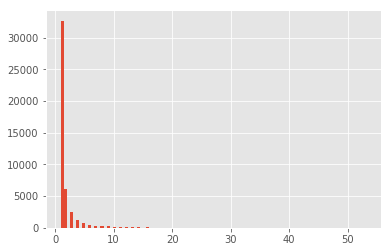

In [24]:
plt.hist(casts_df["actor_id"].value_counts(), bins=100)

In [25]:
np.sum(casts_df["actor_id"].value_counts() > 9)

901

In [26]:
# keep only actors appearing 5 or more times
casts_df = casts_df.groupby("actor_id").filter(lambda x: len(x) > 9 )

In [27]:
new_actor_id_table = np.column_stack((casts_df.actor_id.unique(), range(len(casts_df.actor_id.unique()))))
new_actor_id_table = pd.DataFrame(new_actor_id_table, columns=['actor_id', 'new_actor_id'])
casts_df = pd.merge(casts_df, new_actor_id_table, left_on="actor_id", right_on="actor_id")

In [28]:
casts_df.describe()

,movie_id,cast_id,character,credit_id,gender,actor_id,name,order,new_actor_id
count,14097,14097,14097,14097,14097,14097,14097,14097,14097
unique,2853,238,11872,14097,3,901,901,106,901
top,87818,3,Himself,52fe48f7c3a36847f81828a9,2,2231,Samuel L. Jackson,0,67
freq,29,824,49,1,10526,53,53,2124,53


In [29]:
tmdb.columns

Index([u'budget', u'genres', u'original_language', u'popularity',
       u'production_companies', u'production_countries', u'revenue',
       u'runtime', u'spoken_languages', u'vote_average', u'vote_count',
       u'movie_id', u'cast', u'log_profit_rate'],
      dtype='object')

In [30]:
# too many distince production companies. dont use this information
production_companies_list = [(np.array(pd.read_json(tmdb['production_companies'][row])), \
               tmdb["movie_id"][row]) for row in tmdb.index]
production_companies = np.concatenate([np.column_stack(\
                                         (np.tile(old_movie_id, production_companies.shape[0]), \
                                         production_companies)) \
                        for production_companies, old_movie_id in production_companies_list \
                        if production_companies.shape[0] > 0 ])
production_companies_df = pd.DataFrame(production_companies, columns=['movie_id', 'id', 'name'])
print(production_companies_df.head())
print(production_companies_df.describe())

  movie_id   id                                    name
0    19995  289                 Ingenious Film Partners
1    19995  306  Twentieth Century Fox Film Corporation
2    19995  444                      Dune Entertainment
3    19995  574                Lightstorm Entertainment
4      285    2                    Walt Disney Pictures
        movie_id     id          name
count      10275  10275         10275
unique      3167   3554          3533
top           16   6194  Warner Bros.
freq          26    280           280


In [31]:
pd.read_json(tmdb['spoken_languages'][0])

,iso_639_1,name
0,en,English
1,es,Español


In [32]:
production_countries_list = [(np.array(pd.read_json(tmdb['production_countries'][row])), \
               tmdb["movie_id"][row]) for row in tmdb.index]
production_countries = np.concatenate([np.column_stack(\
                                        (np.tile(old_movie_id, production_countries.shape[0]), \
                                         production_countries)) \
                        for production_countries, old_movie_id in production_countries_list \
                        if production_countries.shape[0] > 0 ])
production_countries_df = pd.DataFrame(production_countries, columns=['movie_id', 'iso_3166_1', 'name'])
print(production_countries_df.head())
print(production_countries_df.describe())

  movie_id iso_3166_1                      name
0    19995         US  United States of America
1    19995         GB            United Kingdom
2      285         US  United States of America
3   206647         GB            United Kingdom
4   206647         US  United States of America
        movie_id iso_3166_1                      name
count       4478       4478                      4478
unique      3189         61                        61
top           16         US  United States of America
freq          12       2888                      2888


In [33]:
new_country_table = np.column_stack((production_countries_df.iso_3166_1.unique(), range(len(production_countries_df.iso_3166_1.unique()))))
new_country_table = pd.DataFrame(new_country_table, columns=['iso_3166_1', 'new_country_id'])
production_countries_df = pd.merge(new_country_table, production_countries_df, left_on="iso_3166_1", right_on="iso_3166_1")

In [34]:
spoken_languages_list = [(np.array(pd.read_json(tmdb['spoken_languages'][row])), \
               tmdb["movie_id"][row]) for row in tmdb.index]
spoken_languages = np.concatenate([np.column_stack(\
                                        (np.tile(old_movie_id, spoken_languages.shape[0]), \
                                         spoken_languages)) \
                        for spoken_languages, old_movie_id in spoken_languages_list \
                        if spoken_languages.shape[0] > 0 ])
spoken_languages_df = pd.DataFrame(spoken_languages, columns=['movie_id', 'iso_639_1', 'name'])
print(spoken_languages_df.head())
print(spoken_languages_df.describe())

  movie_id iso_639_1      name
0    19995        en   English
1    19995        es   Español
2      285        en   English
3   206647        fr  Français
4   206647        en   English
        movie_id iso_639_1     name
count       4896      4896     4896
unique      3198        76       57
top        14161        en  English
freq           9      3111     3111


In [35]:
new_lang_table = np.column_stack((spoken_languages_df.iso_639_1.unique(), range(len(spoken_languages_df.iso_639_1.unique()))))
new_lang_table = pd.DataFrame(new_lang_table, columns=['iso_639_1', 'new_lang_id'])
spoken_languages_df = pd.merge(spoken_languages_df, new_lang_table, left_on="iso_639_1", right_on="iso_639_1")

In [36]:
casts_df["movie_id"].describe()

count     14097
unique     2853
top       87818
freq         29
Name: movie_id, dtype: int64

In [37]:
clean_mv = pd.Series(list(set(casts_df["movie_id"]) & \
                           set(genres_df["movie_id"]) & \
                           set(production_companies_df["movie_id"]) & \
                           set(spoken_languages_df["movie_id"]) & \
                           set(production_countries_df["movie_id"])))

In [38]:
clean_mv.astype('category').describe()

count       2828
unique      2828
top       417859
freq           1
dtype: int64

In [39]:
casts_df = casts_df[casts_df["movie_id"].isin(clean_mv)]
genres_df = genres_df[genres_df["movie_id"].isin(clean_mv)]
tmdb = tmdb[tmdb["movie_id"].isin(clean_mv)]
production_companies_df = production_companies_df[production_companies_df["movie_id"].isin(clean_mv)]
spoken_languages_df = spoken_languages_df[spoken_languages_df["movie_id"].isin(clean_mv)]
production_countries_df = production_countries_df[production_countries_df["movie_id"].isin(clean_mv)]

In [40]:
casts_df.head()

,movie_id,cast_id,character,credit_id,gender,actor_id,name,order,new_actor_id
0,19995,242,Jake Sully,5602a8a7c3a3685532001c9a,2,65731,Sam Worthington,0,0
1,534,6,Marcus Wright,52fe424ec3a36847f8013fcd,2,65731,Sam Worthington,1,0
2,57165,4,Perseus,52fe4926c3a36847f818b907,2,65731,Sam Worthington,0,0
3,18823,1,Perseus,52fe479e9251416c7509fe41,2,65731,Sam Worthington,0,0
4,10592,40,as Cpl. B.J. 'Depot' Guidry,52fe438f9251416c7501522f,2,65731,Sam Worthington,19,0


In [41]:
new_movie_id_table = np.column_stack((clean_mv, range(len(clean_mv))))
new_movie_id_table = pd.DataFrame(new_movie_id_table, columns=['movie_id', 'new_movie_id'])

In [42]:
new_movie_id_table["movie_id"] = new_movie_id_table["movie_id"].astype('object')
tmdb["movie_id"] = tmdb["movie_id"].astype('object')

In [43]:
casts_df = pd.merge(casts_df, new_movie_id_table, left_on="movie_id", right_on="movie_id")
genres_df = pd.merge(genres_df, new_movie_id_table, left_on="movie_id", right_on="movie_id")
tmdb = pd.merge(tmdb, new_movie_id_table, left_on="movie_id", right_on="movie_id")
production_companies_df = pd.merge(production_companies_df, new_movie_id_table, left_on="movie_id", right_on="movie_id")
spoken_languages_df = pd.merge(spoken_languages_df, new_movie_id_table, left_on="movie_id", right_on="movie_id")
production_countries_df = pd.merge(production_countries_df, new_movie_id_table, left_on="movie_id", right_on="movie_id")

In [44]:
casts_df.to_csv("../dat/tmdb_proc/casts_df_clean.csv", encoding='utf-8')

In [45]:
genres_df.to_csv("../dat/tmdb_proc/genres_df_clean.csv")

In [46]:
tmdb.to_csv("../dat/tmdb_proc/tmdb_clean.csv")

In [47]:
production_companies_df.to_csv("../dat/tmdb_proc/production_companies_clean.csv", encoding='utf-8')

In [48]:
production_countries_df.to_csv("../dat/tmdb_proc/production_countries_clean.csv", encoding='utf-8')

In [49]:
spoken_languages_df.to_csv("../dat/tmdb_proc/spoken_languages_clean.csv", encoding='utf-8')